In [1]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import OneHotEncoder, MinMaxScaler, and FunctionTransformer from sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer

# Import Pipeline and FeatureUnion
from sklearn.pipeline import Pipeline, FeatureUnion

# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Import LogisticRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression

# Import LinearSVC from sklearn.svm
from sklearn.svm import LinearSVC

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

# Import roc_auc_score from sklearn.metrics
from sklearn.metrics import roc_auc_score

In [2]:
# Import the final working data (encoded)
train_df = pd.read_csv('./Intermediate_Data/encoded_train.csv', encoding='utf-8', index_col=0)

# Import the test data
test_df = pd.read_csv('./Intermediate_Data/encoded_test.csv', encoding='utf-8', index_col=0)

### Model Approach
For the development of this model, I will be using pipelines with an encoding step (OneHotEncoder) and a modeling step (LogisticRegression/LinearSVC/DecisionTreeClassifier/RandomForestClassifier)). I will attempt a combination of different variables (exclude some of the variables that were determined as poor predictors of the target variable). Additionally, I may choose to apply feature importance to the non-binary categorical data to do some feature selection if the model is having difficulty training.

Additionally, I may choose to performing some preprocessing steps on the numerical data depending on the performance of the model.

### Metrics
For the Kaggle competition, the scoring is done via area under the ROC curve

In [3]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,ONGOING_CREDIT,TOTAL_CLOSED,CLOSED_CREDIT,MONTHS_BALANCE,SK_DPD,NET_PAID,PREV_CREDIT,DAYS_TERMINATION,NET_PAYMENT,PAYMENT_TIME
0,100002,1,0,1,0,202500.0,406597.5,24700.5,0,7,...,2.0,383067.0,6.0,0.0,0.0,0.0,3402045.0,-17.0,0.000,-388.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1,4,...,1.0,207400.5,3.0,0.0,0.0,0.0,10159641.0,-527.0,0.000,-179.0
2,100004,0,1,1,0,67500.0,135000.0,6750.0,0,7,...,0.0,189037.8,2.0,0.0,0.0,0.0,60318.0,-714.0,0.000,-23.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,0,7,...,0.0,0.0,0.0,-1.0,0.0,0.0,3745395.0,0.0,0.000,-310.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,0,7,...,0.0,146250.0,1.0,0.0,0.0,0.0,9733149.0,0.0,-29857.365,-240.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 42 columns):
SK_ID_CURR                    307511 non-null int64
TARGET                        307511 non-null int64
NAME_CONTRACT_TYPE            307511 non-null int64
FLAG_OWN_REALTY               307511 non-null int64
CNT_CHILDREN                  307511 non-null int64
AMT_INCOME_TOTAL              307511 non-null float64
AMT_CREDIT                    307511 non-null float64
AMT_ANNUITY                   307511 non-null float64
NAME_TYPE_SUITE               307511 non-null int64
NAME_INCOME_TYPE              307511 non-null int64
NAME_EDUCATION_TYPE           307511 non-null int64
NAME_FAMILY_STATUS            307511 non-null int64
NAME_HOUSING_TYPE             307511 non-null int64
REGION_POPULATION_RELATIVE    307511 non-null float64
DAYS_BIRTH                    307511 non-null int64
DAYS_EMPLOYED                 307511 non-null int64
DAYS_REGISTRATION             307511 non-null flo

In [96]:
# Define the categorical and numerical column

# Define the numerical columns. All the dtype float64s are numerical columns
NUMERICAL = [col for col in train_df if train_df[col].dtype == 'float64']

# I'll define the additional numerical columns here
ADD_NUMERICAL = ['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DOCUMENTS']

# Define the complete numerical list
NUMERICAL += ADD_NUMERICAL

# Define the categorical columns. All columns not found in the NUMERICAL list
CATEGORICAL = [col for col in train_df if col not in NUMERICAL]

# Sanity Check
assert len(train_df.columns) == (len(NUMERICAL) + len(CATEGORICAL))

In [6]:
# Define the columns to remove that were deemed as poor predictors
TO_REMOVE = ['OWN_CAR_AGE', 'ENQUIRIES', 'SK_DPD', 'DAYS_TERMINATION', 'VALID_MOBILE']

# Remove the columns from the training data
train_df.drop(TO_REMOVE, axis=1, inplace=True)

# Remove the columns from the test data
test_df.drop(TO_REMOVE, axis=1, inplace=True)

In [7]:
# Remove poor predictors from CATEGORICAL list
for col in ['VALID_MOBILE', 'SK_ID_CURR', 'TARGET']:
    CATEGORICAL.remove(col)

# Remove poor predictors from NUMERICAL list
for col in ['OWN_CAR_AGE', 'ENQUIRIES', 'SK_DPD', 'DAYS_TERMINATION']:
    NUMERICAL.remove(col)

In [8]:
# Remove SK_ID_cURR??? since it's supposed to be the index not a training variable

# Split the data into X(variables) and y(target)
X = train_df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = train_df['TARGET']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
# Define a function to match the sample submission format
def submission(prediction):
    '''Creates the dataframe for the predictions and proper formatting'''
    submit = test_df[['SK_ID_CURR']].copy()
    submit['TARGET'] = prediction
    return submit

In [10]:
# Use FunctionTransformer to retrieve the categorical data and numerical data
get_categorical = FunctionTransformer(lambda x: x[CATEGORICAL], validate=False)

get_numerical = FunctionTransformer(lambda x: x[NUMERICAL], validate=False)

In [11]:
# Let's see if the function transformers work
assert len(CATEGORICAL) == len(get_categorical.fit_transform(train_df).columns)
assert len(NUMERICAL) == len(get_numerical.fit_transform(train_df).columns)

In [12]:
# Create a FeatureUnion with a nested pipeline
process_join_features = FeatureUnion(
        transformer_list=[
            ('numeric', Pipeline([
                ('selector', get_numerical),
                ('scaler', MinMaxScaler())
            ])),
            ('categorical', Pipeline([
                ('selector', get_categorical),
                ('encoder', OneHotEncoder())
            ]))
        ])

To determine feature importance, I can't use the Pipeline. I will manually fit my data into a LogisticRegression model and use that to determine feature importance.

In [32]:
# Fit the numerical data to the MinMaxScaler()
NUMERICAL_X_train = MinMaxScaler().fit_transform(X_train[NUMERICAL])

In [33]:
# Fit the converted data to the LogisticRegression()
LogReg = LogisticRegression().fit(NUMERICAL_X_train, y_train)

In [79]:
# Extract the feature importances and zip it with the columns into a dataframe
importances = LogReg.coef_.tolist()
NUMERICAL_df = pd.DataFrame(list(zip(NUMERICAL, importances[0])))
NUMERICAL_df.sort_values(by=1, inplace=True)

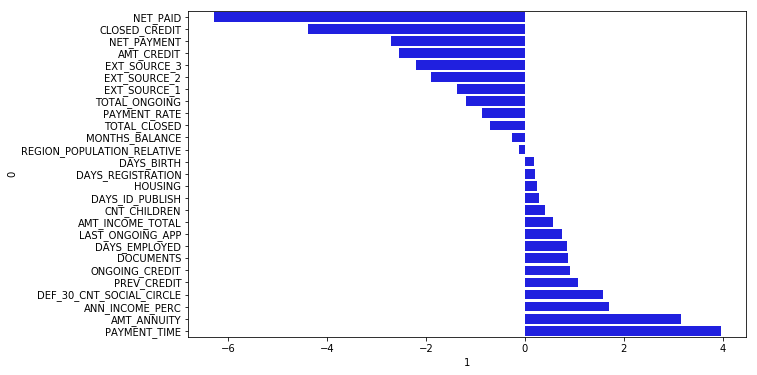

In [93]:
# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=NUMERICAL_df[1], y=NUMERICAL_df[0], color='blue', orient='h')

It may be a good idea to remove some of the less important features, namely, MONTHS_BALANCE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_REGISTRATION, and HOUSING

#### LogisticRegression

In [14]:
# Create the Pipeline with LogisticRegression
lrPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', LogisticRegression())
])

# Fit the Pipeline with the training data
lrPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001B89DBEAF28>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [15]:
predicted_train_values = lrPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = lrPipeline.predict_proba(X_test)[:, -1]

In [16]:
print (roc_auc_score(y_test, predicted_test_values))

0.7412630603962672


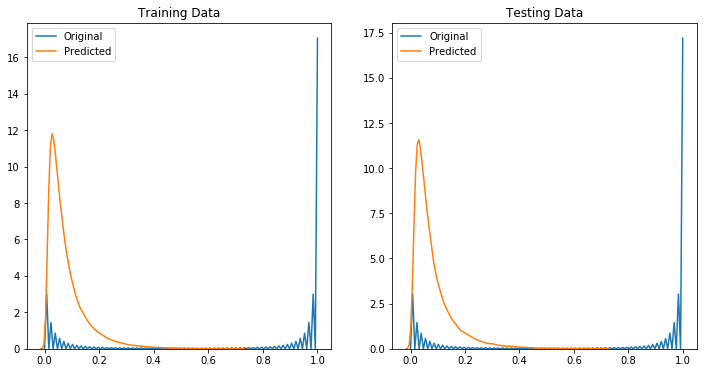

In [17]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [18]:
# Generate the predictions from the pipeline
lrPredicted = lrPipeline.predict_proba(test_df)[:, -1]

# Create the submission dataframe
lrPredictions = submission(lrPredicted)

# Write the predictions to a csv file
lrPredictions.to_csv('./Submissions//lrPredictions.csv', encoding='utf-8', index=False)

#### Decision Tree

In [19]:
# Create the Pipeline with DecisionTreeClassifier
dtPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', DecisionTreeClassifier())
])

# Fit the Pipeline with the training data
dtPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001B89DBEAF28>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [20]:
predicted_train_values = dtPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = dtPipeline.predict_proba(X_test)[:, -1]

In [21]:
print (roc_auc_score(y_test, predicted_test_values))

0.5442168213183867


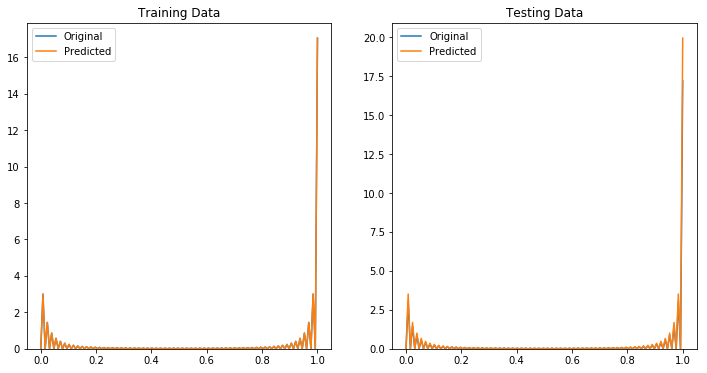

In [23]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [24]:
# Generate the predictions from the pipeline
dtPredicted = dtPipeline.predict_proba(test_df)[:, -1]

# Create the submission dataframe
dtPredictions = submission(dtPredicted)

# Write the predictions to a csv file
dtPredictions.to_csv('./Submissions//dtPredictions.csv', encoding='utf-8', index=False)

#### RandomForestClassifier

In [25]:
# Create the Pipeline with RandomForestClassifier
rfPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', RandomForestClassifier())
])

# Fit the Pipeline with the training data
rfPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001B89DBEAF28>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [26]:
predicted_train_values = rfPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = rfPipeline.predict_proba(X_test)[:, -1]

In [27]:
print (roc_auc_score(y_test, predicted_test_values))

0.6518432804499553


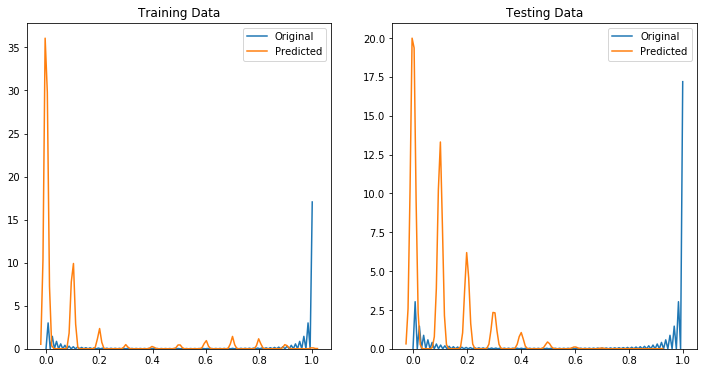

In [28]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [29]:
# Generate the predictions from the pipeline
rfPredicted = rfPipeline.predict_proba(test_df)[:, -1]

# Create the submission dataframe
rfPredictions = submission(rfPredicted)

# Write the predictions to a csv file
rfPredictions.to_csv('./Submissions//rfPredictions.csv', encoding='utf-8', index=False)

 #### LinearSVC

In [30]:
# Create the Pipeline with LinearSVC
svcPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', LinearSVC())
])

# Fit the Pipeline with the training data
svcPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001B89DBEAF28>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [31]:
predicted_train_values = svcPipeline.decision_function(X_train)#[:, -1]
predicted_test_values = svcPipeline.decision_function(X_test)#[:, -1]

In [32]:
predicted_train_values

array([-0.94834681, -1.00733976, -1.09105936, ..., -0.7744862 ,
       -0.79626673, -0.90074986])

In [33]:
print (roc_auc_score(y_test, predicted_test_values))

0.7411814703759567


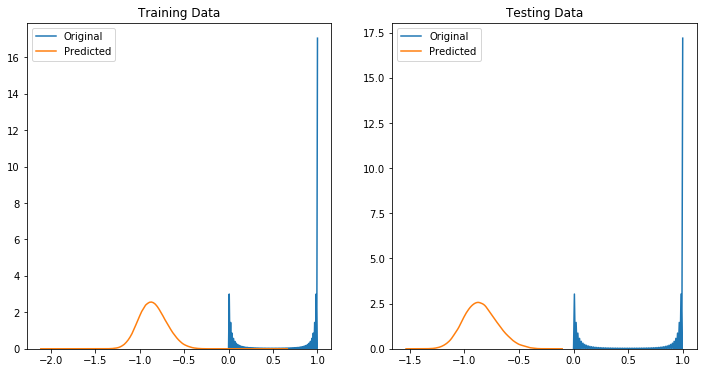

In [34]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [38]:
# Normalize the training predictions
predicted_train_values = (predicted_train_values-predicted_train_values.
                          min()) / (predicted_train_values.max()-predicted_train_values.min())

# Normalize the testing predictions
predicted_test_values = (predicted_test_values-predicted_test_values.
                          min()) / (predicted_test_values.max()-predicted_test_values.min())

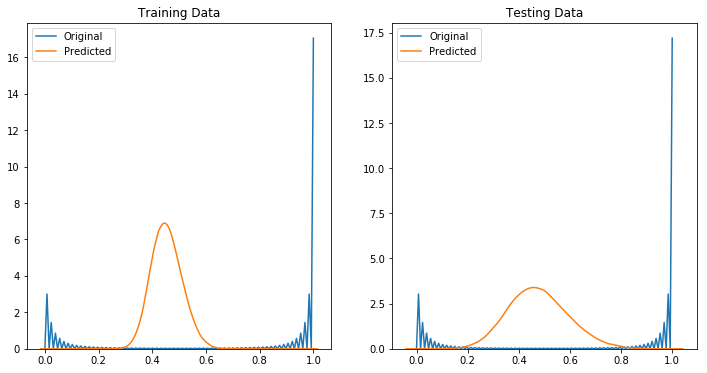

In [39]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [40]:
print (roc_auc_score(y_test, predicted_test_values))

0.7411814703759567


In [41]:
# Generate the predictions from the pipeline
svcPredicted = svcPipeline.decision_function(test_df)#[:, -1]

# Create the submission dataframe
svcPredictions = submission(svcPredicted)

In [42]:
# Normalize the predictions
svcPredictions['TARGET'] =(svcPredictions['TARGET']-svcPredictions['TARGET'].
                min())/(svcPredictions['TARGET'].max()-svcPredictions['TARGET'].min())

In [43]:
svcPredictions.describe()

,SK_ID_CURR,TARGET
count,48744.000000,48744.000000
mean,277796.676350,0.385605
std,103169.547296,0.132730
min,100001.000000,0.000000
25%,188557.750000,0.277598
50%,277549.000000,0.403144
75%,367555.500000,0.483699
max,456250.000000,1.000000


In [44]:
# Write the predictions to a csv file
svcPredictions.to_csv('./Submissions//svcPredictions.csv', encoding='utf-8', index=False)